# Evaluate DOTA dataset

In [1]:
%matplotlib inline
%config IPCompleter.greedy=True
import numpy as np
import matplotlib.pyplot as plt
import os

from dotadevkit.misc.DOTA import DOTA
from dotadevkit.misc.DOTA2COCO import DOTA2COCO
from dotadevkit.misc import dota_utils

import pylab

import detectron2
import io
import os
import json

import cv2
import random
import torch, torchvision
import PIL

from detectron2.config import *
from detectron2.modeling import build_model
from detectron2 import model_zoo
from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.evaluation import RotatedCOCOEvaluator, DatasetEvaluators, inference_on_dataset, coco_evaluation, DatasetEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer

torch.cuda.set_device(0)

pylab.rcParams['figure.figsize'] = (10.0, 10.0)

In [ ]:
# As of 0.3 the XYWHA_ABS box is not supported in the visualizer, this is fixed in master branch atm (19/11/20)
class myVisualizer(Visualizer):
    def draw_dataset_dict(self, dic):
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYWHA_ABS) for x in annos]

            labels = [x["category_id"] for x in annos]
            names = self.metadata.get("thing_classes", None)
            if names:
                labels = [names[i] for i in labels]
            labels = [
                "{}".format(i) + ("|crowd" if a.get("iscrowd", 0) else "")
                for i, a in zip(labels, annos)
            ]
            self.overlay_instances(labels=labels, boxes=boxes, masks=masks, keypoints=keypts)

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            sem_seg = cv2.imread(dic["sem_seg_file_name"], cv2.IMREAD_GRAYSCALE)
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)
        return self.output

In [2]:
TRAIN_PATH = 'datasets/DOTA/train'

dota_train = DOTA(TRAIN_PATH)


In [3]:
imgids = dota_train.getImgIds(catNms=["small-vehicle", "large-vehicle"])
imgid = imgids[0]
img = dota_train.loadImgs(imgid)[0]

isarralike: False
imgids: ['P2030']
filename: datasets/DOTA/train/images/P2030.png


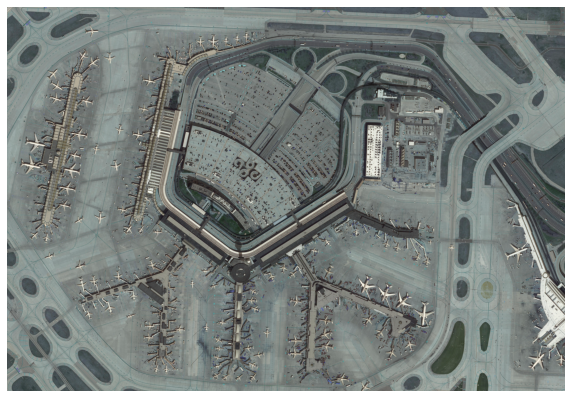

In [4]:
plt.axis('off')

plt.imshow(img)
plt.show()

anns = dota_train.loadAnns(imgId=imgid)
# print(anns)
dota_train.showAnns(anns, imgid, 2)


## Prepare dataset for Detectron

In [3]:
from datasets.DOTA.dota_tools import dota2coco, dota2detectron, wordlist

# convert to coco
# dota2coco(TRAIN_PATH, TRAIN_PATH+"/coco_test.json")
# train_dataset = dota2detectron(TRAIN_PATH)

In [9]:
# # Store DOTA into coco format json
# coco_train_json_path = os.path.join(TRAIN_PATH, 'coco_test.json')
# if not os.path.exists(coco_train_json_path):
#     DOTA2COCO(TRAIN_PATH, coco_train_json_path)

In [4]:
DatasetCatalog.clear()
MetadataCatalog.clear()

# image_path = os.path.join(TRAIN_PATH, "images")
# register_coco_instances("DOTA_train", {}, coco_train_json_path, image_path)
# train_catalog = DatasetCatalog.get("DOTA_train")
DatasetCatalog.register("Train", lambda: dota2detectron(TRAIN_PATH, True))
MetadataCatalog.get("Train").set(thing_classes=wordlist)

namespace(name='Train',
          thing_classes=['plane',
                         'baseball-diamond',
                         'bridge',
                         'ground-track-field',
                         'small-vehicle',
                         'large-vehicle',
                         'ship',
                         'tennis-court',
                         'basketball-court',
                         'storage-tank',
                         'soccer-ball-field',
                         'roundabout',
                         'harbor',
                         'swimming-pool',
                         'helicopter',
                         'container-crane'])

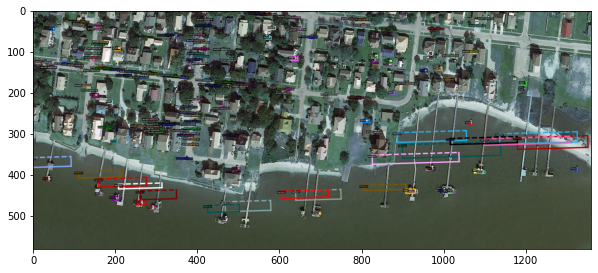

In [6]:

train_catalog = dota2detectron(TRAIN_PATH, True)
for d in random.sample(train_catalog, 1):
    img = cv2.imread(d["file_name"])
    visualizer = myVisualizer(img[:, :, ::-1], metadata=MetadataCatalog.get("Train"), scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()

In [8]:
train_catalog[0]['annotations']

{'category_id': 4,
 'bbox': [2546.5,
  2773.0,
  20.402849197387695,
  12.641709327697754,
  -2.896613990462929],
 'bbox_mode': <BoxMode.XYWHA_ABS: 4>}